# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu bionic-sec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Next, set up virtual display，and import all necessaary packages.

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [ ]:
print(reward)

-0.8588900517154912


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

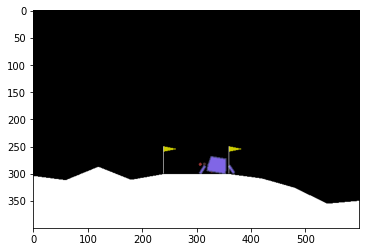

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
# References of DQN
# https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html
# https://flyyufelix.github.io/2017/10/12/dqn-vs-pg.html

In [ ]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.001
LR = 0.0001
UPDATE_STEP = 4

In [ ]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)
        self.relu = nn.ReLU()
    def forward(self, state):
        hid = self.relu(self.fc1(state))
        hid = self.relu(self.fc2(hid))
        return self.fc3(hid)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [ ]:
from collections import deque, namedtuple
# store previous experience
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.action_size = 4
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.exp = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done):
        new = self.exp(state, action, reward, next_state, done)
        self.memory.append(new)
    # sample a batch of experience
    def sample(self):
        exps = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in exps if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in exps if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in exps if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in exps if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float()
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

In [ ]:
from torch.optim.lr_scheduler import StepLR
class Agent():
    def __init__(self, network):
        self.qnetwork_local = network
        self.qnetwork_target = network
        self.optimizer = optim.RMSprop(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.time_step = 0
        # self.seed = random.seed(seed)
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        # learn every UPDATE_STEP time steps
        self.time_step = (self.time_step + 1) % UPDATE_STEP
        if self.time_step == 0:
            if len(self.memory) > BATCH_SIZE:
                exp = self.memory.sample()
                self.learn(exp, GAMMA)
    # produce action
    def act(self, state, eps=0, test=False):
        state = torch.from_numpy(state).float().unsqueeze(0)
        if test:
            action_val = self.qnetwork_local(state)
            return np.argmax(action_val.data.numpy())
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_val = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_val.cpu().data.numpy())
        else:
            return random.choice(np.arange(4))
    def learn(self, exps, gamma):
        states, actions, rewards, next_states, dones = exps

        # produce maximum estimated value of next state
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.smooth_l1_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
    def soft_update(self, local_model, target_model, tau):
        # theta_target = tau * theta_local + (1 - tau) * theta_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

Lastly, build a network and agent to start training.

In [ ]:
network = QNetwork()
agent = Agent(network)

In [ ]:
# agent.qnetwork_local.load_state_dict(torch.load('/content/drive/MyDrive/ML/ML_HW12/checkpoint_best.pth'))

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
total_rewards = []
scores_window = deque(maxlen=100)
eps = 0.9 # initialize epsilon
NUM_EPISODE = 2000
MAX_STEP = 1000
steps_done = 0
for episode in tqdm(range(NUM_EPISODE)):
    state = env.reset()
    total_reward = 0
    for step in range(MAX_STEP):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    total_rewards.append(total_reward)
    scores_window.append(total_reward)
    eps = 0.05 + (0.9 - 0.05) * \
        np.exp(-1. * steps_done / 200)
    steps_done += 1
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0	Average Score: -235.97
Episode 100	Average Score: -174.19
Episode 200	Average Score: -102.96
Episode 300	Average Score: -17.78
Episode 400	Average Score: 17.65
Episode 500	Average Score: 80.48
Episode 600	Average Score: -31.09
Episode 700	Average Score: -33.67
Episode 800	Average Score: 76.87
Episode 900	Average Score: 71.52
Episode 1000	Average Score: 68.48
Episode 1100	Average Score: 92.98
Episode 1200	Average Score: 127.74
Episode 1300	Average Score: 150.13
Episode 1400	Average Score: 116.97
Episode 1500	Average Score: 120.84
Episode 1600	Average Score: 144.73
Episode 1700	Average Score: 124.95
Episode 1800	Average Score: 143.97
Episode 1900	Average Score: 145.85
Episode 2000	Average Score: 106.86
Episode 2100	Average Score: 129.46
Episode 2200	Average Score: 124.52
Episode 2300	Average Score: 145.69
Episode 2400	Average Score: 181.99
Episode 2500	Average Score: 201.62
Episode 2600	Average Score: 206.48
Episode 2700	Average Score: 209.50
Episode 2800	Average Score: 171.08


In [ ]:
torch.save(agent.qnetwork_local.state_dict(), '/content/drive/MyDrive/ML/ML_HW12/checkpoint.pth')

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


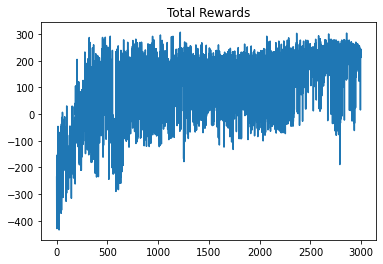

In [ ]:
plt.plot(total_rewards)
plt.title("Total Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


239.03296492183424
184.692746901874
253.55025869332968
130.28582421540602
181.16417865298982


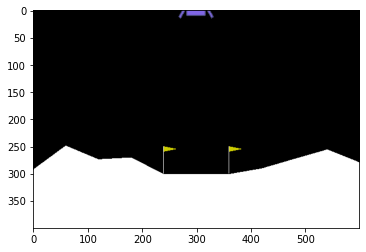

In [ ]:
fix(env, seed)
agent.qnetwork_local.load_state_dict(torch.load('/content/drive/MyDrive/ML/ML_HW12/checkpoint.pth'))
agent.qnetwork_local.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = agent.act(state, test=True)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


In [ ]:
print(np.mean(test_total_reward))

197.74519467708674


Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 2, 3, 2, 1, 2, 0, 2, 0, 3, 2, 0, 2, 0, 2, 0, 1, 2, 3, 2, 2, 2, 1, 2, 2, 0, 2, 3, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 3, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 3, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 3, 2, 3, 2, 3, 1, 2, 2, 2, 3, 2, 3, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 3, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, 2, 3, 1, 2, 3, 1, 2, 2, 3, 2, 2, 3, 1, 2, 3, 1, 2, 2, 3, 2, 2, 0, 2, 0, 2, 2, 3, 1, 2, 2, 3, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 3, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{0: 646, 1: 333, 2: 1515, 3: 354}


Saving the result of Model Testing


In [ ]:
PATH = "/content/drive/MyDrive/ML/ML_HW12/Action_List_DQN.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


Your reward is : 227.38
Your reward is : 27.89
Your reward is : 274.13
Your reward is : 240.68
Your reward is : 236.13


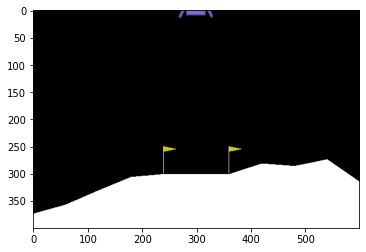

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

# agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 201.24


In [ ]:
# best: 201
# 2000 epoch
# RMSprop with lr = 0.0001
# MAX_STEP = 1000

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
